In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Tuning and deploy a foundation model

Creating an LLM requires massive amounts of data, significant computing resources, and specialized skills. On Vertex AI, tuning allows you to customize a foundation model for more specific tasks or knowledge domains.

While the prompt design is excellent for quick experimentation, if training data is available, you can achieve higher quality by tuning the model. Tuning a model enables you to customize the model response based on examples of the task you want the model to perform.

For more details on tuning have a look at the [official documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models).

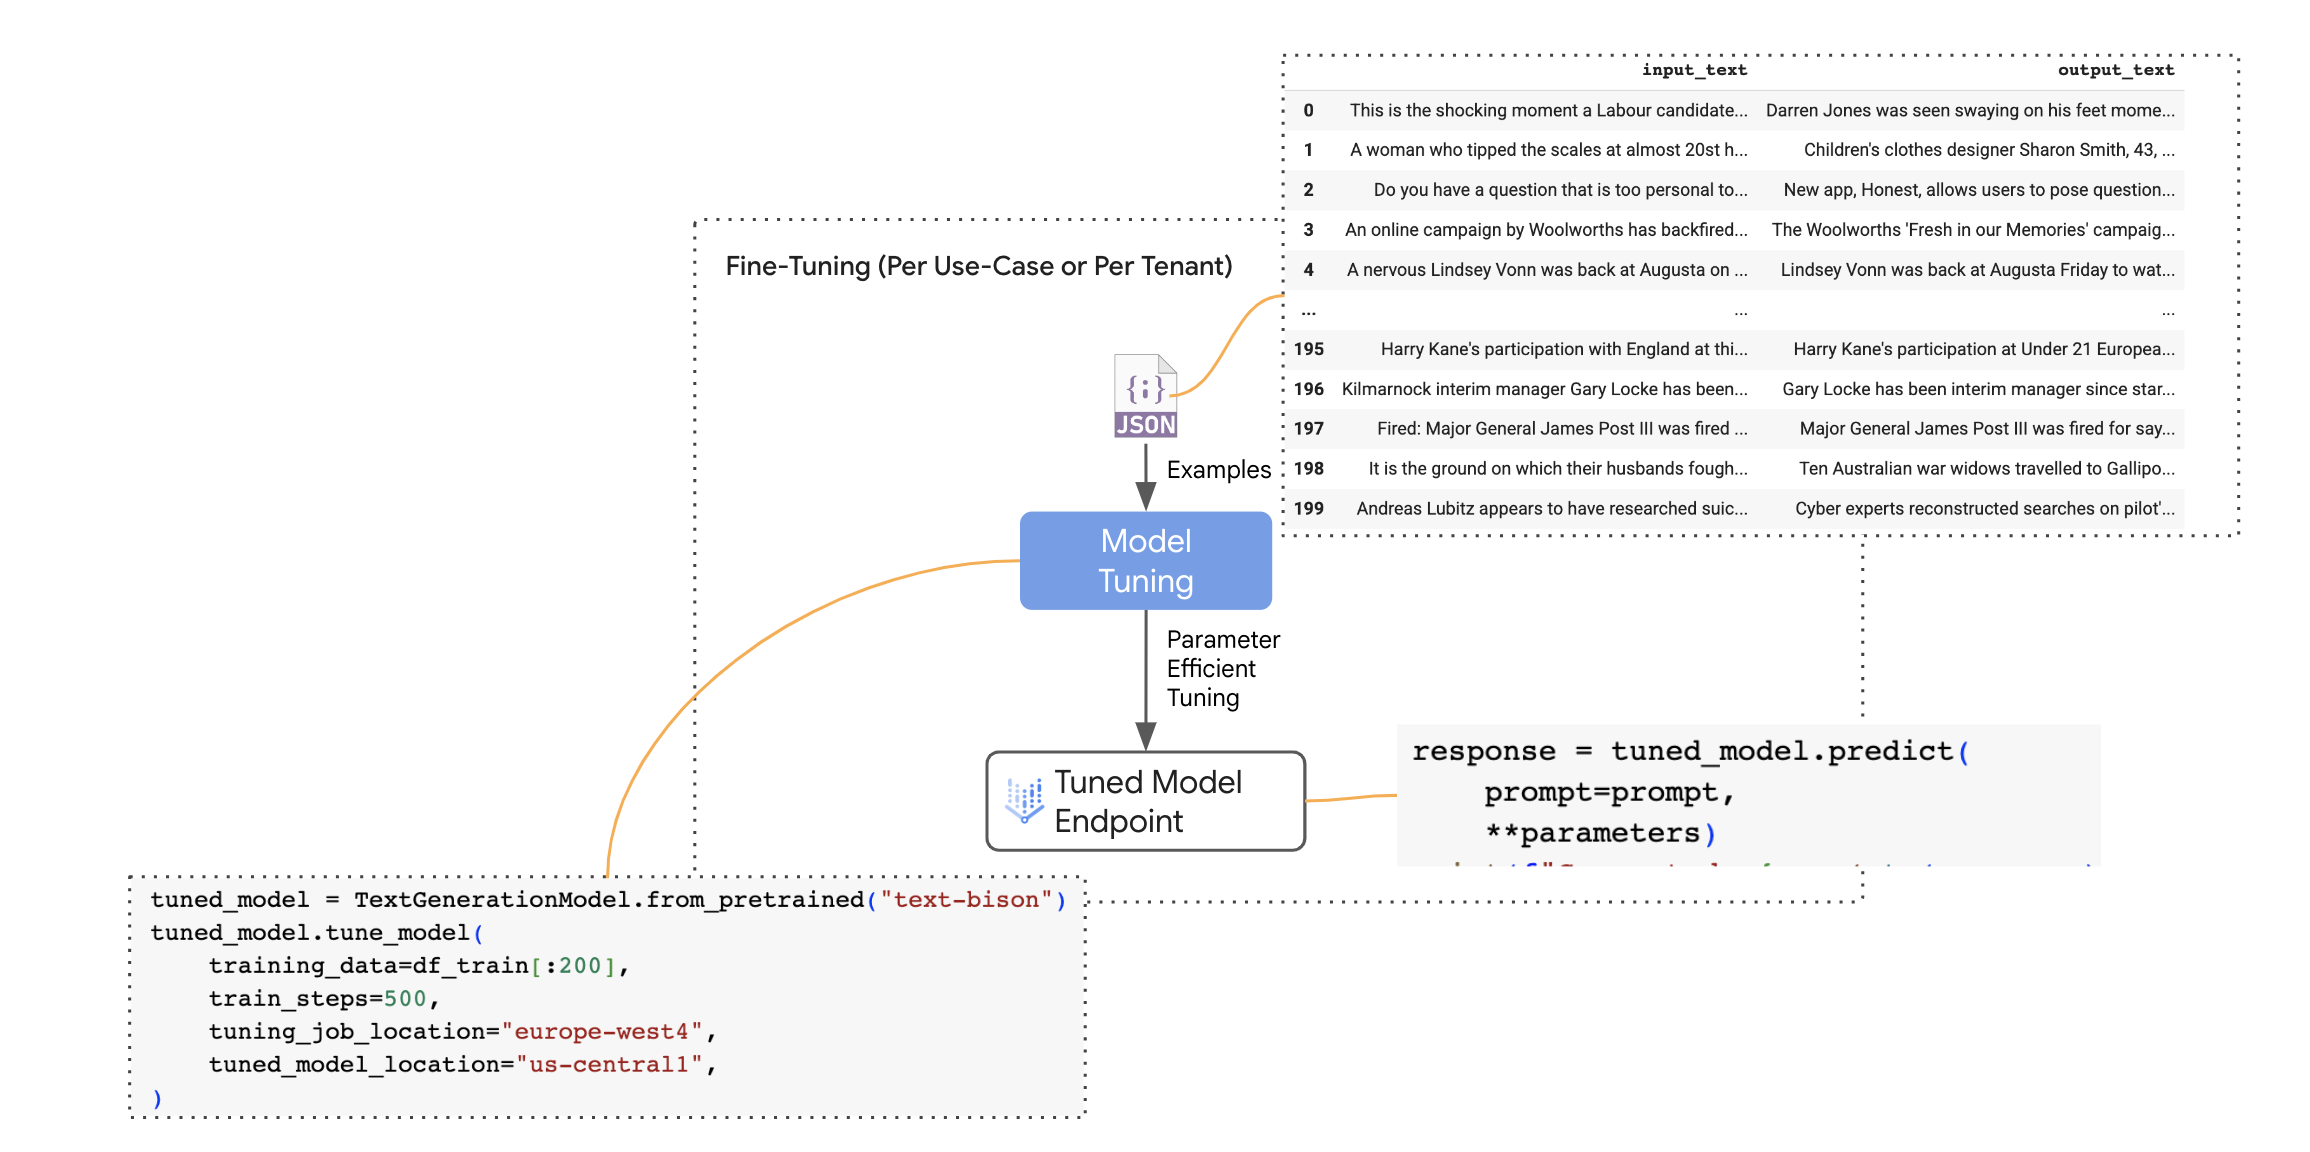

# Tuning workflow for Summarization task on custom dataset

In [ ]:
# Install Vertex AI LLM SDK (Private Preview)
! pip install google-cloud-aiplatform
# Install HuggingFace Datasets
! pip install datasets

! pip install shapely --upgrade



  Using cached Shapely-1.8.5.post1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.0 MB)
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1


  Using cached shapely-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.28.0 requires shapely<2.0.0, but you have shapely 2.0.1 which is incompatible.


In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
from typing import Union
from ast import literal_eval
import textwrap

from datasets import load_dataset
import pandas as pd

from vertexai.preview.language_models import TextGenerationModel,\
                                            ChatModel,\
                                            InputOutputTextPair,\
                                            TextEmbeddingModel
from google.cloud import aiplatform

In [ ]:
PROJECT_ID = "cloud-llm-preview1"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

In [ ]:
aiplatform.init(project=PROJECT_ID, location=LOCATION)

We will work with CNN/Daily Mail dataset, which is a text summarization dataset with human generated abstractive summary bullets that were generated from news stories in CNN and Daily Mail websites

In [ ]:
# Load Dataset
dataset = load_dataset("cnn_dailymail", data_dir='3.0.0', split='test')
dataset = dataset.train_test_split(test_size=0.3)

In [ ]:
dataset.shape

{'train': (8043, 3), 'test': (3447, 3)}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 8043
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 3447
    })
})

In [ ]:
dataset['train'][0]

{'article': "Roberto Carlos has revealed his desire to one day become manager of Brazil and the former Real Madrid defender claims he finds coaching 'very easy' after the pressures he faced as a player. The 42-year-old, a World Cup winner in 2002, has already worked on the sidelines in Turkey with Sivasspor and  Akhisar Belediyespor. He guided Sivasspor to sixth place in the 2013-14 Turkish Super Lig but departed in December after a poor start the following year. Roberto Carlos claims to find coaching 'easy' and is targeting becoming the manager of Brazil . As a player with Brazil, Carlos (right) won the 2002 World Cup held in Japan and South Korea . Carlos (second left) celebrates winning the Champions League in 2000 by beating Valencia 3-0 in the final . Despite that, Carlos has not had his confidence shaken and aims to eventually lead Brazil. 'My objective is to coach the national team,' Carlos said to\xa0Folha de Sao Paulo. 'I know I have a long way to go yet and for that reason I 

In [ ]:
# create separate dataframe for train and test
src_cols = ['article', 'highlights']
df_train = pd.DataFrame(dataset['train'], columns=src_cols)
df_test = pd.DataFrame(dataset['test'], columns=src_cols)

# rename column names in dataframe
df_train.rename(columns={'article': 'input_text', 'highlights': 'output_text'}, inplace=True)
df_test.rename(columns={'article': 'input_text', 'highlights': 'output_text'}, inplace=True)

df_train.head()

,input_text,output_text
0,Roberto Carlos has revealed his desire to one ...,Roberto Carlos says the pressures faced as a p...
1,Politicians' living quarters are under close i...,Etiquette expert and author William Hanson on ...
2,Police in Delaware charged a woman with fatall...,Temitope Adebamiro arrested Friday and charged...
3,If you were spellbound by the death-defying ad...,"Motiongate Dubai will open in October, 2016 wi..."
4,(CNN)Two pieces of audio recorded in the immed...,"In the first recording, an unidentified office..."


In [ ]:
df_test.head()

,input_text,output_text
0,Lionel Messi has confirmed he is to be a fathe...,Lionel Messi posted a picture of his son and w...
1,Jose Mourinho insists Manchester United's inju...,"United are without Marcos Rojo, Phil Jones, Mi..."
2,Andy Lee will leave New York with his head hel...,"Judges scored the contest 113-112, 112-113, 11..."
3,A 16-year-old schoolboy has died after falling...,"Joshua Smith, 16, died in hospital after being..."
4,Forecasters cautioned millions of people in Mi...,Massive hailstones already fell Wednesday duri...


In [ ]:
model = TextGenerationModel.from_pretrained("text-bison@001")
parameters = {
    "max_output_tokens": 256,
    "temperature": 0.0,
    "top_k": 40,
    "top_p": 0.8,
}

## Zero-shot

In [ ]:
def wrap(s):
    return '\n'.join(textwrap.wrap(s))

In [ ]:
context = df_test['input_text'][3]
prompt = f"Summarize: {context}"

print(f"{wrap(prompt)}")
print("*"*80)

print(f"Highlights: {wrap(df_test['output_text'][3])}")
print("*"*80)

response = model.predict(
    prompt=prompt,
    **parameters)
print(f"Generated: {wrap(str(response))}")

Summarize: A 16-year-old schoolboy has died after falling from a cliff
and plunging into the sea in the middle of the night. The teenager,
named as Joshua Smith, was plucked from the water by the crew of an
RAF rescue helicopter and flown to hospital, where he was later
pronounced dead. Police today said that the teen's death was not being
treated as suspicious, but have referred it to the police watchdog.
Joshua Smith died after falling from a cliff and plunging into the sea
in the coastal town of Berwick-upon-Tweed in Northumberland (pictured)
A major air and sea search and rescue operation was launched after
emergency services received reports that someone had fallen from the
cliff at Spittal Point, Berwick-upon-Tweed, Northumberland. The
coastguard, police, paramedics, firefighters and an RAF rescue
helicopter were all scrambled to the scene in early hours of Easter
Sunday. Police have said they are not treating Joshua's death as
suspicious (file picture) RNLI station manager, John

## Few-Shot

In [ ]:
exemplers = [f'Article: {input_text} \nSummary: {output_text.strip()}'
           for input_text, output_text in df_test.head(2).values]
exemplers = '\n\n'.join(exemplers)

context = df_test['input_text'][3]
prompt = f"{exemplers} \n\nArticle: {context}, \nSummary: "

print(f"{wrap(prompt)}")
print("*"*80)

print(f"Highlights: {wrap(df_test['output_text'][3])}")
print("*"*80)

response = model.predict(
    prompt=prompt,
    **parameters)
print(f"Generated: {wrap(str(response))}")

Article: Lionel Messi has confirmed he is to be a father again after
posting a picture of his pregnant wife on social media. Messi took to
Instagram to post a picture of his son, Thiago, kissing his wife
Antonella Roccuzzo’s stomach with the message: ‘Waiting for you baby.
We love you.’ And according to Argentine newspaper Clarin the couple
already know they are due to have a baby boy and have a name for him.
Lionel Messi posted a picture on his Instagram account of his wife
having her stomach kissed by their son . The couple are reported to
have settled on the name Benjamin – the same name his good friend and
international team-mate Sergio Aguero picked for his son. Messi and
Roccuzzo’s first son, Thiago, was born in November 2012 and the
Barcelona superstar has his handprints tattooed on his calf. But one
way Thiago has not followed his famous father is how he deals with the
spotlight of fame. He has been spotted crying when his dad tries to
take him out on the pitch. Messi carries h

## Tuning

In [ ]:
model_display_name = 'cnn_news_summarizer'
tuned_model = TextGenerationModel.from_pretrained("text-bison")

In [ ]:
df_train[:200]

,input_text,output_text
0,She recently revealed her then boyfriend Jerr...,The Fashion Police host dated actor Jerry from...
1,Bayer Leverkusen has released Emir Spahic from...,Emir Spahic sacked with immediate effect by Ba...
2,"After many years of speculation, Bunkie King h...",Bunkie King was a 15-year-old Sydney schoolgir...
3,Mauricio Pochettino believes Harry Kane deserv...,Harry Kane has been nominated for the PFA Play...
4,"(CNN)Italians have a saying: ""Too much of some...",Italy boasts the highest number of UNESCO Worl...
...,...,...
195,(CNN)Tobacco companies including Philip Morris...,Companies including Philip Morris and R.J. Rey...
196,Set side by side it’s hard to believe they’re ...,Photos obtained by Daily Mail Online show surg...
197,Bobby Flay is said to be offering his soon-to-...,Bobby and Stephanie separated three weeks ago ...
198,(CNN)Hip-hop star Nelly has been arrested on d...,State troopers say they found methamphetamine ...


In [ ]:
df_train[:200].to_json("df_train.json")

In [ ]:
tuned_model.tune_model(
    training_data=df_train[:200],
    # Optional:
    train_steps=500,
    tuning_job_location="europe-west4",
    tuned_model_location="us-central1",
)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/tune-large-model-20230712141318?project=801452371447


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/tune-large-model-20230712141318?project=801452371447


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/801452371447/locations/europe-west4/pipelineJobs/tune-large-model-20230712141318 current state:
PipelineState.PIPELINE_STATE_RUNNING


In [ ]:
_tuned_model = aiplatform.Model(model_name=tuned_model._endpoint.gca_resource.deployed_models[0].model)
_tuned_model = _tuned_model.update(display_name=model_display_name)

In [ ]:
tuned_model = TextGenerationModel.get_tuned_model(tuned_model_name=_tuned_model.name)

In [ ]:
context = df_test['input_text'][3]
prompt = f"Summarize: {context}"

print(f"Article: {wrap(prompt)}")
print("*"*80)

print(f"Highlights: {wrap(df_test['output_text'][3])}")
print("*"*80)

response = tuned_model.predict(
    prompt=prompt,
    **parameters)
print(f"Generated: {wrap(str(response))}")

Article: Summarize: Ludogorets player Cosmin Moti is guilty of producing one of
the worst tackles you're likely to see this season after his kung-fu
style tackle on a CSKA Sofia player - but unbelievably the referee
waved play on. It was a kick Eric Cantona would have been proud of, as
he connected cleanly with Stefan Nikolic's rib-cage and sending his
opponent crashing to the floor. The defender made the headlines for
the right reasons during Ludogorets Champions League play-off against
Steaua Bucharest back in August, when he saved two penalties during
the shoot-out - after their goalkeeper had been sent off. Cosmin Moti
(centre right) kung-fu tacklesStefan Nikolic during Ludogorets clash
with CSKA Sofia . His heroics sent the Bulgarian side through to the
Champions League group stages as he established himself as a club
legend. But Moti's kick on Nikolic shows a different side and the
misdemeanor during the first half went unpunished as his side went on
to win the contest 4-0 - send

In [ ]:
context = df_test['input_text'][100]
prompt = f"Summarize: {context}"

print(f"Article: {wrap(prompt)}")
print("*"*80)

print(f"Highlights: {wrap(df_test['output_text'][100])}")
print("*"*80)

parameters['max_output_tokens'] = 256
response = tuned_model.predict(
    prompt=prompt,
    **parameters)
print(f"Generated: {wrap(str(response))}")

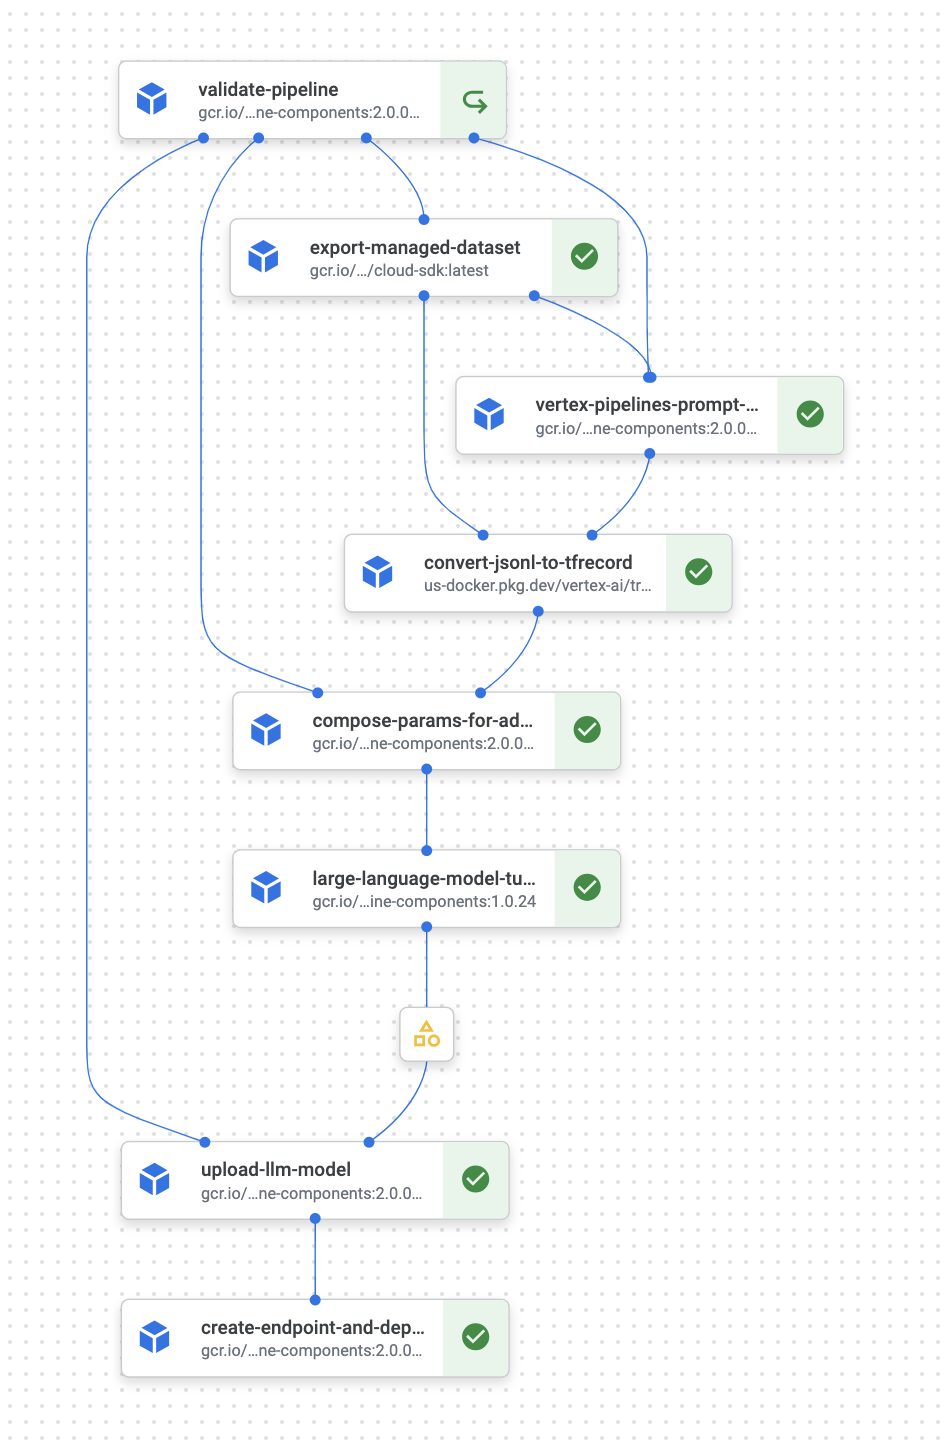

## Recommended configurations

Here are some recommended configurations for tuning a foundation model based on the task:

- Classification:

  - 100+ train set size recommended.
  - Learning Rate = 3.0.
  - Training steps [100-500]. You can try more than one value to get the best performance on a particular dataset (e.g. 100, 200, 500).

- Extractive QA:

  - 100+ train set size recommended
  - Learning Rate = 3.0.
  - Training steps [100-500]. You can try more than one value to get the best performance on a particular dataset (e.g. 100, 200, 500).

- Summarization:

  - 500+ train set size recommended, but at least 100 for decent results.
  - Learning Rate = 3.0
  - Training steps [200-1000]. You can try more than one value to get the best performance on a particular dataset (e.g. 200, 500, 800).
